In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, t, laplace
import seaborn as sns
import os, wget, shutil
from rich import print

os.makedirs("data", exist_ok=True)
link_original = "https://s3.amazonaws.com/openneuro.org/ds004148/participants.tsv?versionId=wt81Mu2B3fdeiXSis5ym288A64lXRXkR"
wget.download(link_original)
filename = "participants.tsv"
file_ = [os.path.join(root, file) for root, _, files in os.walk(os.getcwd()) for file in files if file == filename]
shutil.copy2(file_[0], "data")
os.remove(file_[0])
print(f"\nOriginal file downloaded.")

data = np.array(pd.read_csv("data/"+filename,sep='\s+')["Height"]).reshape(-1,1)
clean_data = data[~np.isnan(data)]

100% [..........................................................] 39886 / 39886

Original file downloaded.

In [ ]:



n_replicates = 2
subsample_sizes = [5, 6]
t1 = list()
t1p = list()
for run in range(n_replicates):
    data = np.random.normal(loc=170, scale=10, size=100)
    for size in subsample_sizes:
        
        subsample = data[:size].copy()
        loo_data = np.array([np.delete(subsample, i) for i in range(len(subsample))])
        
        for loo_subset in loo_data:
            h = list()
            for _ in range(n_replicates):
                if ttest_1samp(loo_subset, 170)[1] < 0.05:
                    h.append(ttest_1samp(loo_subset, 170)[1])
            t1.append(np.mean(h))
            loo_mean, loo_std, loo_tval = user_output_loo_stats(loo_subset)
            noisy_output, sensitivity_ = dp(loo_subset, loo_subset)
            noisy_tstats = noisy_output / (loo_std / np.sqrt(size - 1))
            pvals = 2 * (1 - t.cdf(np.abs(noisy_tstats), df=size-1))
            t1p.append(np.mean(pvals[pvals < 0.05]))
            


In [160]:
def user_output(clean_data):

    pipeline_output = np.mean(clean_data)
    return pipeline_output
def dp_2(data):

    loo_means = np.array([np.mean(np.delete(data, i)) for i in range(len(data))])
    loo_stds = np.array([np.std(np.delete(data, i), ddof=1) for i in range(len(data))])
    mean_sensitivity = np.max(np.abs(loo_means - np.mean(data)))
    std_sensitivity = np.max(np.abs(loo_stds - np.std(data, ddof=1)))
    
    while True:
        noise_mean = np.random.laplace(loc=0.0, scale=mean_sensitivity)
        noise_std = np.random.laplace(loc=0.0, scale=std_sensitivity)

        if abs(noise_mean) >= mean_sensitivity and abs(noise_std) >= std_sensitivity:
            break
            
    return noise_mean, noise_std, mean_sensitivity, std_sensitivity


def user_output_loo_stats(clean_data):
    
    loo_mean = np.array([np.mean(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_std = np.std(loo_mean, ddof=1)#np.sqrt(np.sum((clean_data - loo_mean) ** 2) / len(clean_data) - 1)
    loo_t = loo_mean / (loo_std / np.sqrt(len(clean_data) - 1))

    return loo_mean, loo_std, loo_t


In [140]:
def user_output_loo_stats(clean_data):
    
    loo_mean = np.array([np.mean(np.delete(clean_data, i)) for i in range(len(clean_data))])
    loo_std = np.std(loo_mean, ddof=1)#np.sqrt(np.sum((clean_data - loo_mean) ** 2) / len(clean_data) - 1)
    loo_t = loo_mean / (loo_std / np.sqrt(len(clean_data) - 1))

    return loo_mean, loo_std, loo_t


n_replicates = 2
subsample_sizes = [5, 6]
t1 = list()
t1p = list()
for run in range(n_replicates):
    data = np.random.normal(loc=170, scale=10, size=100)
    for size in subsample_sizes:
        
        subsample = data[:size].copy()
        loo_data = np.array([np.delete(subsample, i) for i in range(len(subsample))])
        
        for loo_subset in loo_data:
            h = list()
            for _ in range(n_replicates):
                if ttest_1samp(loo_subset, 170)[1] < 0.05:
                    h.append(ttest_1samp(loo_subset, 170)[1])
            t1.append(np.mean(h))
            loo_mean, loo_std, loo_tval = user_output_loo_stats(loo_subset)
            noisy_output, sensitivity_ = dp(loo_subset, loo_subset)
            noisy_tstats = noisy_output / (loo_std / np.sqrt(size - 1))
            pvals = 2 * (1 - t.cdf(np.abs(noisy_tstats), df=size-1))
            t1p.append(np.mean(pvals[pvals < 0.05]))
            


In [174]:
np.random.seed(42)
null_true_mu = 170
std_dev = 10
alpha_ = [0.01, 0.05, 0.1]
effect_sizes = [0, 0.2, 0.5, 0.8, 1.0]  
n_simulations = 2
sample_sizes = [5, 10]#[10, 20, 30, 50, 100]

for size in sample_sizes:
    for alpha in alpha_:
        for effect in effect_sizes:
            type_I_standard = 0
            type_I_dp_mean_only = 0
            type_I_dp_mean_std = 0
            power_standard = 0
            power_dp_mean_only = 0
            power_dp_mean_std = 0
            sensitivities = []
            for _ in range(n_simulations):
                true_mean = null_true_mu if effect == 0 else null_true_mu + effect*std_dev
                data = np.random.normal(loc=true_mean, scale=std_dev, size=size)
                
                loo_data = np.array([np.delete(data, i) for i in range(len(data))])
                sample_mean = np.mean(loo_data)
                sample_std = np.std(loo_data, ddof=1)
                
                _, p_standard = ttest_1samp(loo_data, null_true_mu)
                for loo_subset in loo_data:
                    ua,ub,uc = user_output_loo_stats(loo_subset)
                    a,b,c,d = dp_2(loo_subset)
                    
                    print("*"*80)
                    print(f"loo_mean: {ua}, loo_std: {ub}, loo_t: {uc}")
                    print(f"noise_mean: {a}, noise_std: {b}, mean_sensitivity: {c}, std_sensitivity: {d}")
                    print("*"*80)
                    break
                break
                if effect == 0: 
                        type_I_standard += (p_standard < alpha)
                        type_I_dp_mean_only += (p_mean_only < alpha)
                        type_I_dp_mean_std += (p_mean_std < alpha)
                else:  
                    power_standard += (p_standard < alpha)
                    power_dp_mean_only += (p_mean_only < alpha)
                    power_dp_mean_std += (p_mean_std < alpha)
                
                    sensitivities.append((mean_sens, std_sens))
            

            results.append({
                'sample_size': size,
                'alpha': alpha,
                'effect_size': effect,
                'type_I_standard': type_I_standard/n_simulations if effect == 0 else np.nan,
                'type_I_dp_mean_only': type_I_dp_mean_only/n_simulations if effect == 0 else np.nan,
                'type_I_dp_mean_std': type_I_dp_mean_std/n_simulations if effect == 0 else np.nan,
                'power_standard': power_standard/n_simulations if effect != 0 else np.nan,
                'power_dp_mean_only': power_dp_mean_only/n_simulations if effect != 0 else np.nan,
                'power_dp_mean_std': power_dp_mean_std/n_simulations if effect != 0 else np.nan,
                'mean_sensitivity': np.mean([s[0] for s in sensitivities]),
                'std_sensitivity': np.mean([s[1] for s in sensitivities])
            })

            break
        break
    break

********************************************************************************

loo_mean: [176.45521673 173.83537394 170.91756954 176.77484698], loo_std: 2.7247791871988545,
loo_t: [112.16666733 110.50132107 108.64657061 112.36984557]

noise_mean: -7.702840739524856, noise_std: 4.3971473344764656, mean_sensitivity: 
3.5781822558482475, std_sensitivity: 3.3360152986639715

********************************************************************************

In [145]:
def calc_sens(data):
    loo_means = np.array([np.mean(np.delete(data, i)) for i in range(len(data))])
    loo_stds = np.array([np.std(np.delete(data, i), ddof=1) for i in range(len(data))])
    mean_sensitivity = np.max(np.abs(loo_means - np.mean(data)))
    std_sensitivity = np.max(np.abs(loo_stds - np.std(data, ddof=1)))
    
    return mean_sensitivity, std_sensitivity

def add_noise(clean_data, pipeline_mean, pipeline_std):
    
    mean_sens, std_sens = calc_sens(clean_data)
    noisy_mean = pipeline_mean + np.random.laplace(loc=0, scale=mean_sens)
    noisy_std = pipeline_std + np.random.laplace(loc=0, scale=std_sens)
    noisy_std = max(noisy_std, 0.1)  
    
    return noisy_mean, noisy_std, mean_sens, std_sens

In [113]:
np.random.seed(42)
null_true_mu = 170
std_dev = 10
sample_sizes = [10, 20, 30, 50, 100]
alpha_ = [0.01, 0.05, 0.1]
effect_sizes = [0, 0.2, 0.5, 0.8, 1.0]  
n_simulations = 1000 

results = []
for size in sample_sizes:
    for alpha in alpha_:
        for effect in effect_sizes:
            type_I_standard = 0
            type_I_dp_mean_only = 0
            type_I_dp_mean_std = 0
            power_standard = 0
            power_dp_mean_only = 0
            power_dp_mean_std = 0
            sensitivities = []
            
            for _ in range(n_simulations):
                true_mean = null_true_mu if effect == 0 else null_true_mu + effect*std_dev
                data = np.random.normal(loc=true_mean, scale=std_dev, size=size)
                _, p_standard = ttest_1samp(data, null_true_mu)
                sample_mean = np.mean(data)
                sample_std = np.std(data, ddof=1)

                noisy_mean1, _, mean_sens, _ = add_noise(data, sample_mean, sample_std)
                t_mean_only = noisy_mean1 / (sample_std/np.sqrt(size))
                p_mean_only = 2 * (1 - t.cdf(abs(t_mean_only), df=size-1))
                
                noisy_mean2, noisy_std2, mean_sens, std_sens = add_noise(data, sample_mean, sample_std)
                t_mean_std = noisy_mean2 / (noisy_std2/np.sqrt(size))
                p_mean_std = 2 * (1 - t.cdf(abs(t_mean_std), df=size-1))
                
                if effect == 0: 
                    type_I_standard += (p_standard < alpha)
                    type_I_dp_mean_only += (p_mean_only < alpha)
                    type_I_dp_mean_std += (p_mean_std < alpha)
                else:  
                    power_standard += (p_standard < alpha)
                    power_dp_mean_only += (p_mean_only < alpha)
                    power_dp_mean_std += (p_mean_std < alpha)
                
                sensitivities.append((mean_sens, std_sens))
            

            results.append({
                'sample_size': size,
                'alpha': alpha,
                'effect_size': effect,
                'type_I_standard': type_I_standard/n_simulations if effect == 0 else np.nan,
                'type_I_dp_mean_only': type_I_dp_mean_only/n_simulations if effect == 0 else np.nan,
                'type_I_dp_mean_std': type_I_dp_mean_std/n_simulations if effect == 0 else np.nan,
                'power_standard': power_standard/n_simulations if effect != 0 else np.nan,
                'power_dp_mean_only': power_dp_mean_only/n_simulations if effect != 0 else np.nan,
                'power_dp_mean_std': power_dp_mean_std/n_simulations if effect != 0 else np.nan,
                'mean_sensitivity': np.mean([s[0] for s in sensitivities]),
                'std_sensitivity': np.mean([s[1] for s in sensitivities])
            })


In [132]:
df = pd.DataFrame(results)

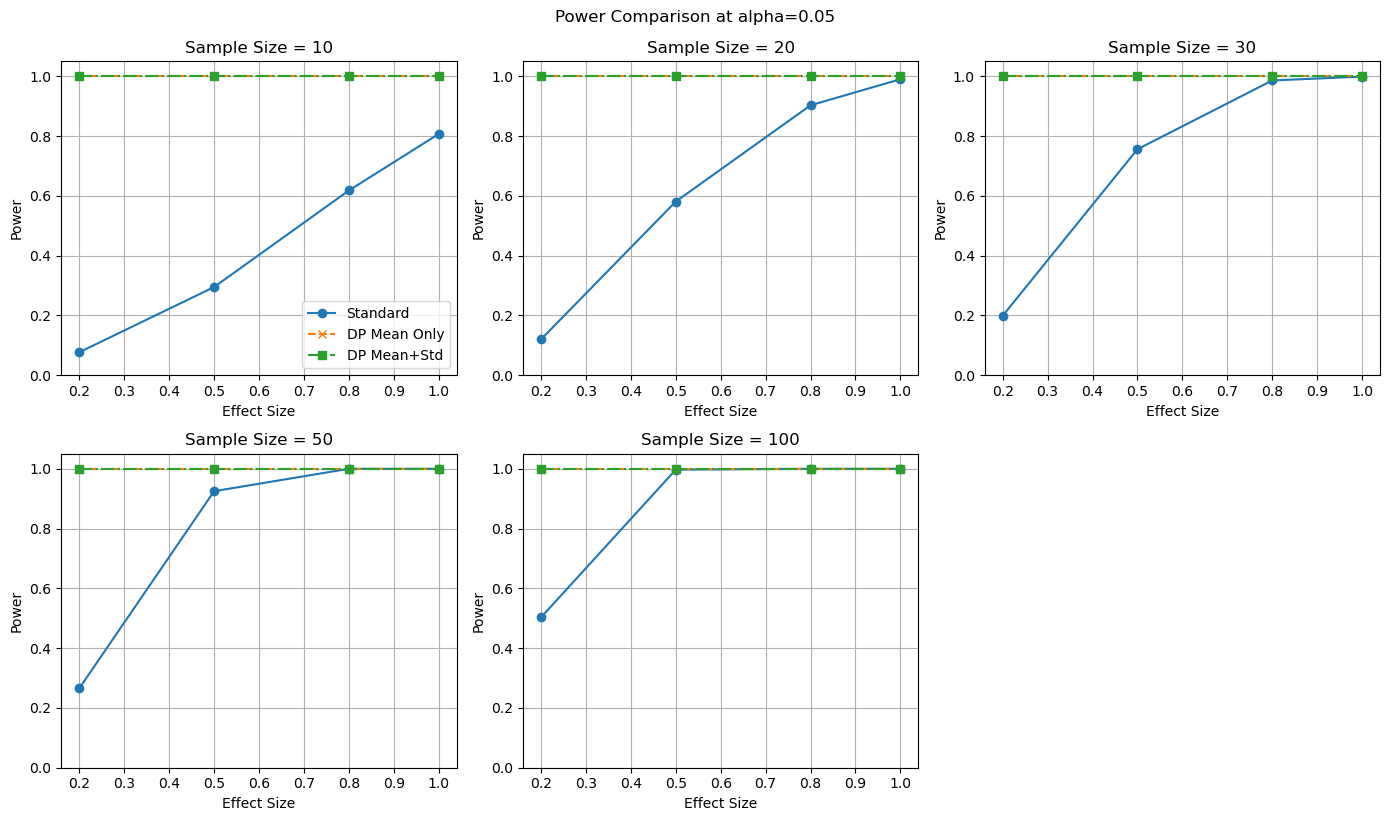

In [137]:
plt.figure(figsize=(14, 8))
for i, size in enumerate(sample_sizes):
    plt.subplot(2, 3, i+1)
    subset = df[(df['alpha'] == 0.05) & (df['sample_size'] == size) & (df['effect_size'] != 0)]
    
    plt.plot(subset['effect_size'], subset['power_standard'], 'o-', label='Standard')
    plt.plot(subset['effect_size'], subset['power_dp_mean_only'], 'x--', label='DP Mean Only')
    plt.plot(subset['effect_size'], subset['power_dp_mean_std'], 's-.', label='DP Mean+Std')
    
    plt.xlabel('Effect Size')
    plt.ylabel('Power')
    plt.title(f'Sample Size = {size}')
    plt.ylim(0, 1.05)
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.suptitle('Power Comparison at alpha=0.05', y=1.02)
plt.show()




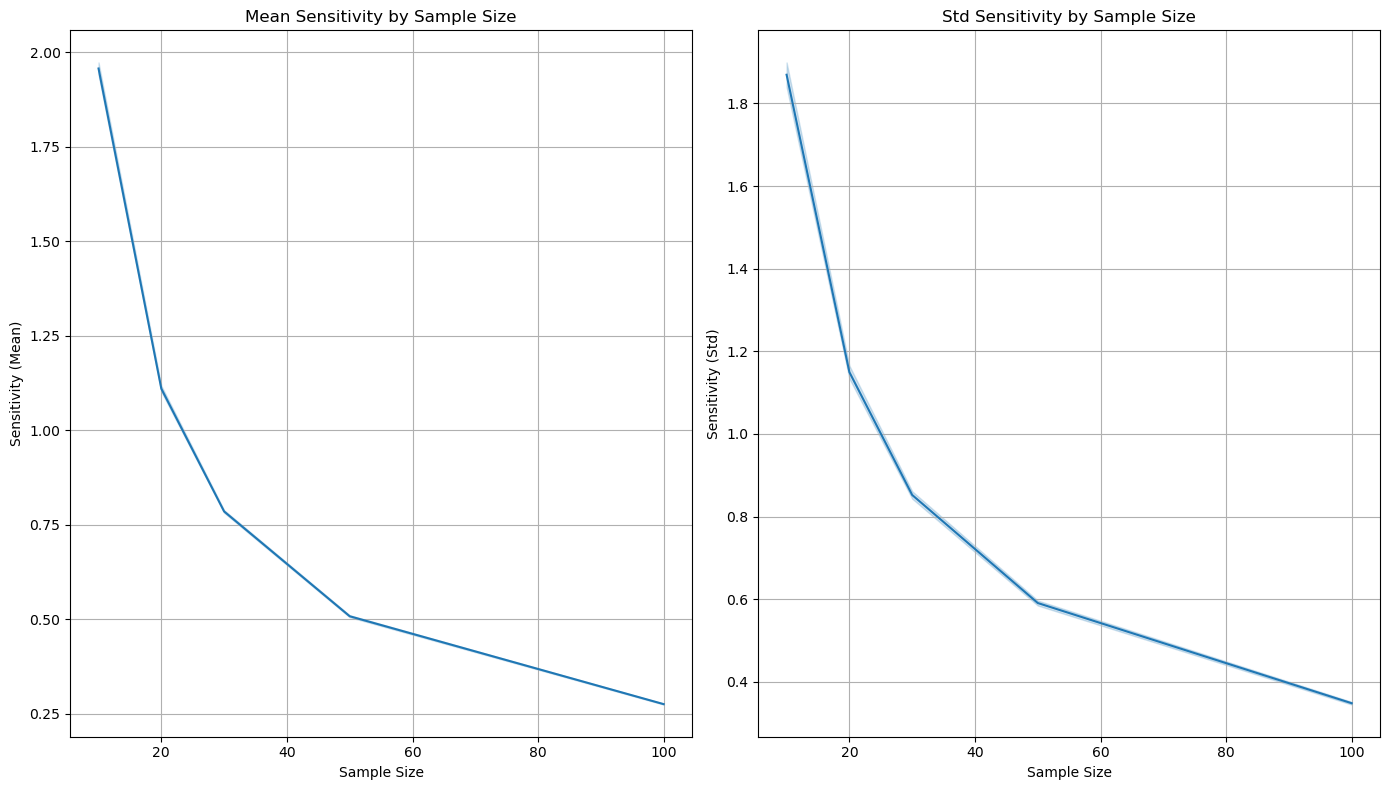

In [131]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
sns.lineplot(x='sample_size', y='mean_sensitivity', data=df, errorbar='sd')
plt.title('Mean Sensitivity by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Sensitivity (Mean)')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(x='sample_size', y='std_sensitivity', data=df, errorbar='sd')
plt.title('Std Sensitivity by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel('Sensitivity (Std)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [119]:
print("Type I Error Rates Summary:")
print()
print(df[df['effect_size'] == 0].groupby(['alpha', 'sample_size'])[
    ['type_I_standard', 'type_I_dp_mean_only', 'type_I_dp_mean_std']].mean())

print("\nPower Comparison Summary (alpha=0.05):")
print(df[(df['alpha'] == 0.05) & (df['effect_size'] != 0)].groupby(['effect_size', 'sample_size'])[
    ['power_standard', 'power_dp_mean_only', 'power_dp_mean_std']].mean())

print("\nAverage Sensitivities:")
print(df.groupby('sample_size')[['mean_sensitivity', 'std_sensitivity']].mean())

Type I Error Rates Summary:

type_I_standard  type_I_dp_mean_only  type_I_dp_mean_std
alpha sample_size                                                          
0.01  10                     0.010                  1.0                 1.0
      20                     0.013                  1.0                 1.0
      30                     0.011                  1.0                 1.0
      50                     0.010                  1.0                 1.0
      100                    0.007                  1.0                 1.0
0.05  10                     0.060                  1.0                 1.0
      20                     0.037                  1.0                 1.0
      30                     0.064                  1.0                 1.0
      50                     0.042                  1.0                 1.0
      100                    0.058                  1.0                 1.0
0.10  10                     0.100                  1.0                 1.0
      20                     0.111                  1.0                 1.0
      30                     0.100                  1.0                 1.0
      50                     0.092                  1.0                 1.0
      100                    0.108                  1.0                 1.0

Power Comparison Summary (alpha=0.05):

power_standard  power_dp_mean_only  power_dp_mean_std
effect_size sample_size                                                       
0.2         10                    0.077                 1.0                1.0
            20                    0.120                 1.0                1.0
            30                    0.199                 1.0                1.0
            50                    0.266                 1.0                1.0
            100                   0.503                 1.0                1.0
0.5         10                    0.295                 1.0                1.0
            20                    0.581                 1.0                1.0
            30                    0.756                 1.0                1.0
            50                    0.925                 1.0                1.0
            100                   0.997                 1.0                1.0
0.8         10                    0.618                 1.0                1.0
            20                    0.903                 1.0                1.0
            30                    0.986                 1.0                1.0
            50                    1.000                 1.0                1.0
            100                   1.000                 1.0                1.0
1.0         10                    0.807                 1.0                1.0
            20                    0.990                 1.0                1.0
            30                    0.999                 1.0                1.0
            50                    1.000                 1.0                1.0
            100                   1.000                 1.0                1.0

Average Sensitivities:

mean_sensitivity  std_sensitivity
sample_size                                   
10                   1.957005         1.869581
20                   1.110203         1.149618
30                   0.785569         0.852225
50                   0.508444         0.590662
100                  0.275990         0.348006

In [167]:
def dp(clean_data,pipeline_output):

    loo_output = np.array([user_output(np.delete(clean_data, i)) for i in range(len(clean_data))])
    print("loo_output: ",loo_output)
    print("pipeline_output: ",pipeline_output)
    loo_scale = np.std(loo_output)
    sensitivity = np.max(np.abs(loo_output - pipeline_output))
    while True:
        noise = np.random.laplace(loc=0.0, scale=loo_scale)
        if abs(noise) >= sensitivity:
            break

    noisy_output = pipeline_output + noise
    return noisy_output, sensitivity
def iqr_bounds(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return iqr, lower_bound, upper_bound

#def outlier_(recons, orig):
#    return isclose(recons, orig, rel_tol=1e-3)
def outlier_(value, lower, upper):
    return value < lower or value > upper
id_dr = {size: np.zeros(size) for size in subsample_sizes} # stands for index detection rates
counts = {size: 0 for size in subsample_sizes}
reconstructed = {size: [] for size in subsample_sizes}
true_means_ = {size: [] for size in subsample_sizes}
sensitivities_ = {size: [] for size in subsample_sizes}
error_ = {size: [] for size in subsample_sizes}
subsample_sizes = [5, 10]
for _ in range(2):
    
    data = np.random.normal(loc=170, scale=10, size=100)
    for size in subsample_sizes:
        original_subsample = data[:size].copy()
        iqr_orig, lower_orig, upper_orig = iqr_bounds(original_subsample)
        outlier_value = lower_orig - 100
        subsample_w = original_subsample.copy()
        subsample_w[0] = outlier_value
        true_mean = np.mean(subsample_w)
        true_means_[size].append(true_mean)
        loo_data = np.array([np.delete(subsample_w, i) for i in range(len(subsample_w))])
        ######## PIPELINE ########
        noisy_outputs = []
        sens_outputs = []
        for loo_subset in loo_data:
            output = user_output(loo_subset)
            noisy_output, sensitivity_ = dp(loo_subset, output)
            noisy_outputs.append(noisy_output)
            sens_outputs.append(sensitivity_)
        ######## RECONSTRUCTION ########
        coeff_mat = np.ones((size, size)) - np.eye(size)
        recons = np.linalg.solve(coeff_mat, (size - 1) * np.array(noisy_outputs))

        recons_error = np.mean(abs(recons - original_subsample))
        error_[size].append(recons_error)
        sensitivities_[size].append(sens_outputs)
        reconstructed[size].append(recons)
   
        #if outlier_(recons[0], original_subsample[0]):
        #    counts[size] += 1

        _, lower_rec, upper_rec = iqr_bounds(recons)
        if outlier_(recons[0], lower_rec, upper_rec):
            counts[size] += 1
            
        for idx in range(size):
            #if outlier_(recons[idx], original_subsample[idx]):
            if outlier_(recons[idx], lower_rec, upper_rec):
                id_dr[size][idx] += 1
        break
    break

loo_output:  [174.68273797 173.63876365 175.59247942 171.52765881]

pipeline_output:  173.86040996501296

loo_output:  [174.68273797 136.4651152  138.41883098 134.35401037]

pipeline_output:  145.98017362847222

loo_output:  [173.63876365 136.4651152  137.37485665 133.31003604]

pipeline_output:  145.19719288297205

loo_output:  [175.59247942 138.41883098 137.37485665 135.26375181]

pipeline_output:  146.6624797157884

loo_output:  [171.52765881 134.35401037 133.31003604 135.26375181]

pipeline_output:  143.61386425785588